In [9]:
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.models import load_model
from keras.layers import InputLayer, Lambda
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.utils.vis_utils import plot_model
from scipy.linalg import sqrtm

In [10]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/'

# Image shape being used
img_shape = (72, 72, 3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Load and return the training data
def load_training_data():
    real_imgs = np.load(path + 'train_x10000x72.npy', allow_pickle=True)

    # Converting image data from doubles to floats
    real_imgs = real_imgs.astype('float32')
    # Scale from [0, 255] to [0, 1]
    real_imgs = real_imgs / 255

    return real_imgs

In [12]:
# Generate random points in the latent space
def generate_latent_points(latent_dim, n_samples):
    # Choose n_samples amount of random points in the latent space
    fake_x_input = np.random.randn(latent_dim * n_samples)
    # Reshape into batches of inputs for the model
    fake_x_input = fake_x_input.reshape(n_samples, latent_dim)

    return fake_x_input

In [13]:
def generate_images(n_samples):
    # Load generator model
    model = load_model(path + '/GAN for 72x72 Output/generator_model_epoch_1000.h5')
    # Generate images
    latent_points = generate_latent_points(100, n_samples)
    gen_imgs = model.predict(latent_points)
    # Scale pixel values from [-1,1] to [0,1]
    gen_imgs = (gen_imgs + 1) / 2.0
    # Reshape images to correct shape
    gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], img_shape[0], img_shape[1], img_shape[2])
    
    return gen_imgs

In [14]:
# calculate frechet inception distance
def calculate_fid(model, real_imgs, fake_imgs):
		# calculate activations
		act1 = model.predict(real_imgs)
		act2 = model.predict(fake_imgs)
		# calculate mean and covariance statistics
		mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
		mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
		# calculate sum squared difference between means
		ssdiff = np.sum((mu1 - mu2)**2.0)
		# calculate sqrt of product between cov
		covmean = sqrtm(sigma1.dot(sigma2))
		# check and correct imaginary numbers from sqrt
		if np.iscomplexobj(covmean):
			covmean = covmean.real
		# calculate score
		fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
		return fid

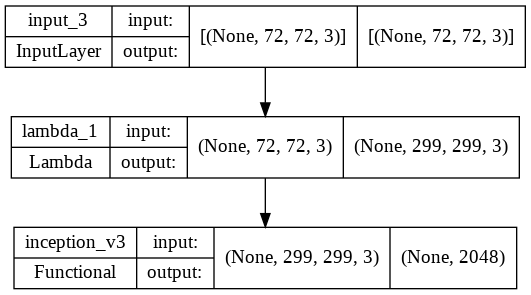

In [15]:
# Define InceptionV3 model with layers to resize images
model = Sequential()
model.add(InputLayer(img_shape))
model.add(Lambda(lambda image: tf.image.resize(image, (299, 299))))
model.add(InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3)))
plot_model(model, show_shapes=True, show_layer_names=True)

In [16]:
# Load real data and generate fake data
real_imgs = load_training_data()
fake_imgs = generate_images(10000)

# Process images
real_imgs = real_imgs.astype('float32')
fake_imgs = fake_imgs.astype('float32')
real_imgs = preprocess_input(real_imgs)
fake_imgs = preprocess_input(fake_imgs)

# Calculate FID Score
fid = calculate_fid(model, real_imgs, fake_imgs)
print('FID: %.3f' % fid)

FID: 0.034
